In [1]:
import numpy as np
from SALib.sample import saltelli, latin
from SALib.analyze import sobol, delta
import matplotlib.pyplot as plt

In [4]:
# Problem setup
d = 3
problem = {
    'num_vars': d,
    'names': ['x'+str(i) for i in range(d)],
    'bounds': [[0, 100] for i in range(d)] # will sample uniformly by default
}

# Sobol g-function, commonly used for testing SA
# low a_i means high dependence on x_i,
# high a_i means low dependence on x_i
a = [(i*2)/10 for i in range(1,d+1)]

# Example function to test sensitivity on
def f(x):
    #return sum([(abs(4*x[i]-2)+a[i])/(1+a[i]) for i in range(d)])
    return x[0]+x[1]+x[2]

#

In [5]:
# Typical delta analysis steps
# usually used with latin hypercube sampling, although delta was designed
# with making the most of preexisting samples in mind

X = latin.sample(problem, 5000) # generate input sample
Y = np.array([f(x) for x in X]) # calculate ouptuts
S = delta.analyze(problem, X, Y, print_to_console=True) # perform analysis

       delta  delta_conf        S1   S1_conf
x0  0.259328    0.011765  0.432834  0.018491
x1  0.210918    0.011295  0.330041  0.019277
x2  0.176058    0.011341  0.246034  0.019397


In [7]:
# Typical sobol/saltelli analysis steps
# must be done with saltelli sampling (low discrepancy sequence)

Xb = saltelli.sample(problem, 2**13) # saltelli sample size needs to be a power of 2
Yb = np.array([f(x) for x in Xb])
Sb = sobol.analyze(problem, Yb, print_to_console=True) # note: unlike delta, does not take X as a parameter
                                                    # saltelli sequence is deterministic for given N,
                                                    # so SALib might recreate X under the hood, have to check

          ST   ST_conf
x0  0.258885  0.007966
x1  0.190201  0.005243
x2  0.145623  0.004508
x3  0.115060  0.003325
x4  0.093199  0.002736
x5  0.077024  0.002456
x6  0.064721  0.001889
x7  0.055147  0.001712
          S1   S1_conf
x0  0.258885  0.012608
x1  0.190201  0.012144
x2  0.145623  0.011603
x3  0.115060  0.010077
x4  0.093199  0.009253
x5  0.077060  0.008859
x6  0.064721  0.007351
x7  0.055183  0.008149
                    S2   S2_conf
(x0, x1)  1.034254e-04  0.022895
(x0, x2)  1.034254e-04  0.021462
(x0, x3)  1.034254e-04  0.018847
(x0, x4)  1.034254e-04  0.022487
(x0, x5) -1.387779e-17  0.022125
(x0, x6)  1.034254e-04  0.021796
(x0, x7)  1.034254e-04  0.021019
(x1, x2) -2.775558e-17  0.018615
(x1, x3) -1.387779e-17  0.018319
(x1, x4)  0.000000e+00  0.017545
(x1, x5) -1.387779e-17  0.017556
(x1, x6)  4.163336e-17  0.017771
(x1, x7)  1.387779e-17  0.017921
(x2, x3) -4.163336e-17  0.018243
(x2, x4) -2.775558e-17  0.017335
(x2, x5) -4.163336e-17  0.017922
(x2, x6) -1.387779e-17  0

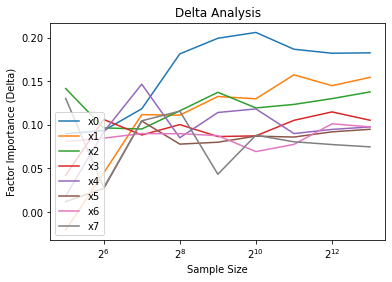

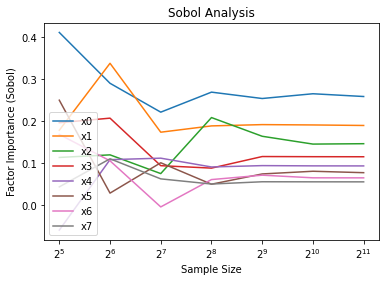

In [3]:
# runs SA on multiple sample size trials, plots results
def show_convergence(problem, func, trials, method='delta'):
    results = np.zeros((len(trials), problem['num_vars']))
    for i, n in enumerate(trials):
        if method == 'delta':
            Xd = latin.sample(problem, n)
            Yd = np.array([func(x) for x in Xd])
            Sd = delta.analyze(problem, Xd, Yd)
            results[i] = Sd['delta']
        elif method == 'sobol':
            Xs = saltelli.sample(problem, n)
            Ys = np.array([func(x) for x in Xs])
            Ss = sobol.analyze(problem, Ys)
            results[i] = Ss['S1']
        else:
            print("use method='delta' (default) or 'sobol'")
            return
    # matplotlib stuff
    plt.figure()
    plt.title('{} Analysis'.format(method.title()))
    plt.xlabel('Sample Size')
    plt.ylabel('Factor Importance ({})'.format(method.title()))
    plt.semilogx(base=2)
    for res in results.T: # plot results columns
        plt.plot(trials, res)
    plt.legend(problem['names'], loc=3)
    plt.show()
    return results

r1 = show_convergence(problem, f, [2**i for i in range(5,16)], 'delta')
r2 = show_convergence(problem, f, [2**i for i in range(5,12)], 'sobol')